# Sprint 機械学習スクラッチ 決定木

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# 評価
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
# 可視化
import matplotlib.pyplot as plt
import japanize_matplotlib
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [9]:
# データセットの作成
X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [13]:
# trainとtestに分ける
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0,test_size=0.3)
print('X_train_shape:',X_train.shape)
print('y_train_shape:',y_train.shape)
print('X_test_shape:',X_test.shape)
print('y_test_shape:',y_test.shape)

X_train_shape: (28, 2)
y_train_shape: (28,)
X_test_shape: (12, 2)
y_test_shape: (12,)


In [15]:
count_left = np.bincount(y_train)
print(count_left)
left = np.argmax(count_left)
print('左子ノードのラベル：',left)
np.unique(y_train, return_counts=True)

[15 13]
左子ノードのラベル： 0


(array([0, 1]), array([15, 13], dtype=int64))

# 【問題1】不純度を求める関数
* ノード の ジニ不純度 を計算する関数を作成
* クラスが混じり合っているほどジニ不純度は高くなる
* メモ：np.unique(y, return_counts=True)とすると，ユニークな値とそれに含まれる要素数が返ってくる
* メモ：np.count_nonzero(c == label)　条件を満たす要素の数が返る

In [54]:
def gini(c):
    # クラスラベル
    n_class = np.unique(c)
    # サンプル数
    n_all = len(c)
    # シグマの初期化
    sigma = 0
    # ひとつひとつのクラスラベルについて計算する
    for label in n_class:
        sigma += (np.count_nonzero(c == label)/len(c))**2
    gini = 1 - sigma
    return gini

### 簡単なサンプルで検証．
* （１）クラス1:サンプル数15, クラス2:サンプル数15 → ジニ不純度0.500
* （２）クラス1:サンプル数15, クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667

In [56]:
a = np.zeros(15)
b = np.ones(15)
c = np.full(15, 2)
# クラス1:サンプル数15, クラス2:サンプル数15 →ジニ不純度0.500
ab = np.concatenate([a,b],axis=0)
# クラス1:サンプル数15,クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667
abc = np.concatenate([a,b,c],axis=0)
print('（１）ab_shape:',ab.shape,'\n',ab)
print('\n（２）abc_shape:',abc.shape,'\n',abc)

（１）ab_shape: (30,) 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]

（２）abc_shape: (45,) 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [57]:
print('(1)',gini(ab))
print('(2)',gini(abc))

(1) 0.5
(2) 0.6666666666666667


# 【問題2】情報利得を求める関数

In [67]:
def information_gain(N,left,right):
    # 親ノードのジニ
    Ip = gini(N)
    print('IP:',Ip)
    # 左子ノード
    left = (len(left)/len(N))*gini(left)
    print('left:',left)
    # 右子ノード
    right = (len(right)/len(N))*gini(right)
    print('right:',right)
    # 情報利得を計算
    IG = Ip - left - right
    print('情報利得:',IG)
    return IG

#### 簡単なサンプルで検証
* 左ノードクラス1:サンプル数10, 左ノードクラス2:サンプル数30, 
* 右ノードクラス1:サンプル数20, 右ノードクラス2:サンプル数5             
→ 情報利得0.143

In [68]:
a = np.zeros(10)
b = np.ones(30)
N_left = np.concatenate([a,b],axis=0)
print('N_left_shape',N_left.shape)
c = np.zeros(20)
d = np.ones(5)
N_right = np.concatenate([c,d],axis=0)
print('N_right_shape',N_right.shape)
N_all = np.concatenate([N_left,N_right],axis=0)
print('N_all_shape',N_all.shape)

N_left_shape (40,)
N_right_shape (25,)
N_all_shape (65,)


In [70]:
information_gain(N_all,N_left,N_right)

IP: 0.4970414201183432
left: 0.23076923076923078
right: 0.12307692307692303
情報利得: 0.14319526627218937


0.14319526627218937

# 【問題3】学習

In [86]:
class ScratchDecesionTreeClassifierDepth1():
    """
    深さ1の決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """

    def __init__(self, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose

    def gini_score(self,c):
        """
        ジニ不純度を計算する
        
        Parameters
        ----------
        c : ndarray
        """
        n_class = np.unique(c)
        n_all = len(c)
        sigma = 0
        for label in n_class:
            sigma += (np.count_nonzero(c == label)/len(c))**2
        gini = 1 - sigma
        return gini    
    
    def information_gain(self,N,left,right):
        """
        情報利得を計算する．
        
        Parameters
        ----------
        N : ndarray (n_samples,n_features)
        left : ndarray (n_sample,)
        right: ndarray (n_samples,)
        """
        Ip = self.gini_score(N)
        left = (len(left)/len(N))*self.gini_score(left)
        right = (len(right)/len(N))*self.gini_score(right)
        IG = Ip - left - right
        return IG
    

    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        """
        # 特徴量の数
        num_features = X.shape[1]
        # forの中でのX
        split_points_list = []
        # 特徴量ごとの情報利得
        info_gain_list = []
        # 特徴量の数だけ回まわして，Xを全部取り出す
        for f in range(num_features):
            # 重複するものは計算しない．
            uniq_feature = np.unique(X[:, f])
            # 情報利得
            ig_list = []
            # 取り出したXすべてでIGを計算していく．
            for val in uniq_feature:
                # x以上ならleft，以下ならright
                n_l,n_r = [y[X[:, f] >= val], y[X[:, f] < val]]
                ig = self.information_gain(y,n_l,n_r)
                ig_list.append(ig)

            # Xを特徴量ごとにリスト化
            split_points_list.append(uniq_feature.tolist())
            # 情報利得を特徴量ごとに保存
            info_gain_list.append(ig_list)
            
        # 特徴量ごとに情報利得が最大なものを取り出す
        for f in range(num_features):
            x_atmax = split_points_list[f][np.where(info_gain_list[f] == np.max(info_gain_list[f]))[0].tolist()[0]]
            y_atmax = np.max(info_gain_list[f])
            max_info_gain = np.max(np.max(info_gain_list))
                  
            # 全特徴量の中から，情報利得が最大のものを記録
            if y_atmax == max_info_gain:
                # 情報利得が最大の列（特徴量）
                self.feature = f
                # その特徴量の値
                self.threshold = x_atmax
                
                
        # 閾値を超えた特徴量は左
        idx_left = X[:, self.feature] >= self.threshold
        idx_right = X[:, self.feature] < self.threshold
        # 閾値を超えたｙは左
        left = y[idx_left]
        right = y[idx_right]
        
        # 多数決
        count_left = np.bincount(left)
        self.left = np.argmax(count_left)
        print('左子ノードのラベル：',self.left)
        count_right = np.bincount(right)
        self.right = np.argmax(count_right)    
        print('右子ノードのラベル',self.right)
        
        #if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            #print()
        #pass
        
    def predict(self,X):
        """
        学習で得た閾値で推定する．

        Parameters
        ----------
        X　: ndarray　shape(n_sample,n_feature)
        """
        return np.where(X[:,self.feature] > self.threshold, self.left,self.right)

In [99]:
# 初期化，学習，推定
tree = ScratchDecesionTreeClassifierDepth1()
tree.fit(X_train,y_train)
y_pred = tree.predict(X_test)
print(y_pred)
print(y_test)

左子ノードのラベル： 1
右子ノードのラベル 0
[1 0 0 0 0 0 0 0 1 1]
[1 1 1 0 0 0 1 0 0 1]


In [100]:
# Accuracy，Precision，Recall
from sklearn.metrics import accuracy_score
print('accuracy:',accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

accuracy: 0.6
              precision    recall  f1-score   support

           0       0.57      0.80      0.67         5
           1       0.67      0.40      0.50         5

   micro avg       0.60      0.60      0.60        10
   macro avg       0.62      0.60      0.58        10
weighted avg       0.62      0.60      0.58        10



# sklearn 決定木

In [102]:
from sklearn.tree import DecisionTreeClassifier
# 初期化，学習，推定
model = DecisionTreeClassifier(criterion='gini',max_depth=1,random_state=0)
model.fit(X_train,y_train)
y_pred_sk = model.predict(X_test)

In [103]:
# Accuracy，Precision，Recall
print('accuracy:',accuracy_score(y_test,y_pred_sk))
print(classification_report(y_test,y_pred_sk))

accuracy: 0.6
              precision    recall  f1-score   support

           0       0.57      0.80      0.67         5
           1       0.67      0.40      0.50         5

   micro avg       0.60      0.60      0.60        10
   macro avg       0.62      0.60      0.58        10
weighted avg       0.62      0.60      0.58        10



# 【問題6】決定領域の可視化

In [104]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title='Decision Region', xlabel='f0', ylabel='f1', target_names=['1', '-1']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
     
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

## １．スクラッチ決定木

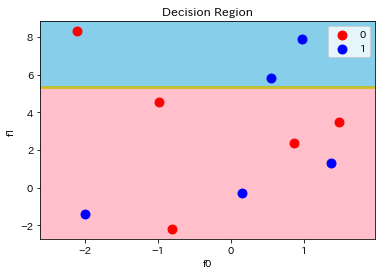

In [105]:
decision_region(X=X_test, y=y_test, model=tree, step=0.01, title='Decision Region', xlabel='f0', ylabel='f1', target_names=['0', '1'])

## ２．sklearn

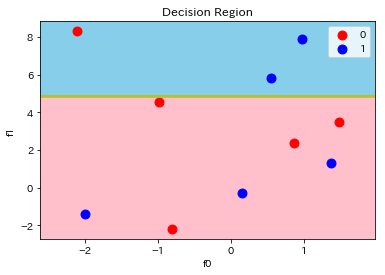

In [106]:
decision_region(X=X_test, y=y_test, model=model, step=0.01, title='Decision Region', xlabel='f0', ylabel='f1', target_names=['0', '1'])